In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'fpga'
SUBTRACT_IDLE = True

match DEVICE:
    case 'cn': IDLE = 3.38
    case 'fpga': IDLE = 53
    case 'laptop': IDLE = 3.00

path_math = f'scripts/{DEVICE}/math.csv'
path_sleepy = f'scripts/{DEVICE}/sleepy.csv'
path_matmul = f'scripts/{DEVICE}/matmul.csv'

In [3]:
def read_csv(path):
    df = pd.read_csv(path)
    df = df[df['dynamic'] == False]
    df.drop(['dynamic'], axis=1, inplace=True)

    df['W'] = df['energy'] / df['runtime']

    if SUBTRACT_IDLE:
        df['energy'] -= df['runtime'] * IDLE
        assert((df['energy'] > 0).all())

    real_max = df['runtime'] * df['threads']
    user_pct = df['usertime'] / real_max
    user_pct = user_pct.clip(upper=1.0)
    df['usertime'] /= df['threads']
    df['user-pct'] = user_pct
    df['energy-user'] = df['energy'] * user_pct

    df0 = df.copy()[df['busy'] == 0]
    return df, df0

In [5]:
df_math,   df_math0   = read_csv(path_math)
df_sleepy, df_sleepy0 = (df_math,   df_math0)#read_csv(path_sleepy)
df_matmul, df_matmul0 = read_csv(path_matmul)
df_matmul

,busy,threads,energy,runtime,usertime,W,user-pct,energy-user
0,0,1,26.049419,0.406121,0.406129,117.141961,1.000000,26.049419
1,0,2,16.041871,0.207266,0.205097,130.397410,0.989532,15.873943
2,0,3,13.154423,0.157722,0.136113,136.402350,0.862989,11.352123
3,0,4,10.416209,0.104352,0.102282,152.817923,0.980163,10.209584
4,0,5,9.312002,0.085883,0.082347,161.426302,0.958820,8.928538
...,...,...,...,...,...,...,...,...
283,32,28,6.475330,0.030903,0.015395,262.535847,0.498181,3.225885
284,32,29,6.605146,0.030683,0.014881,268.273418,0.484983,3.203381
285,32,30,6.257816,0.029651,0.014343,264.046795,0.483709,3.026961
286,32,31,6.641990,0.031516,0.014015,263.747652,0.444679,2.953555


In [6]:
df_math_speedup   = df_math.copy()
df_sleepy_speedup = df_sleepy.copy()
df_matmul_speedup = df_matmul.copy()

for col in df_math_speedup.columns[2:]:
    df_math_speedup[col]   = df_math_speedup[col].iloc[0]   / df_math_speedup[col]
    df_sleepy_speedup[col] = df_sleepy_speedup[col].iloc[0] / df_sleepy_speedup[col]
    df_matmul_speedup[col] = df_matmul_speedup[col].iloc[0] / df_matmul_speedup[col]

df_math_speedup0   = df_math_speedup[df_math_speedup['busy'] == 0]
df_sleepy_speedup0 = df_sleepy_speedup[df_sleepy_speedup['busy'] == 0]
df_matmul_speedup0 = df_matmul_speedup[df_matmul_speedup['busy'] == 0]

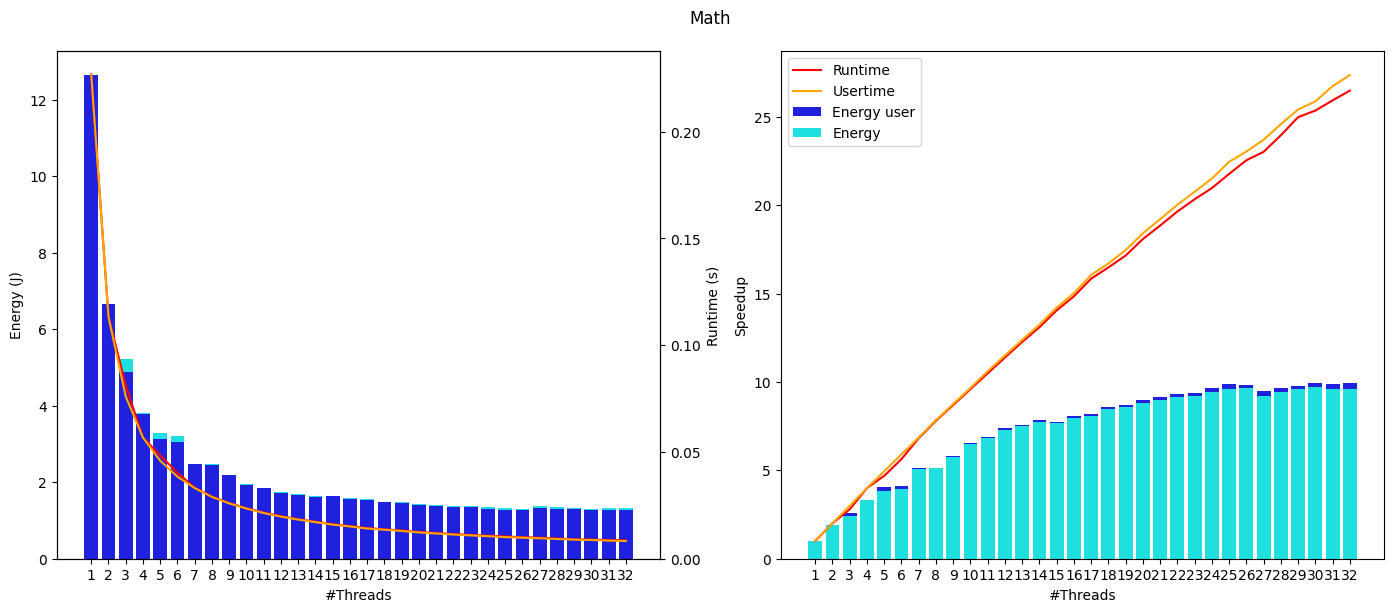

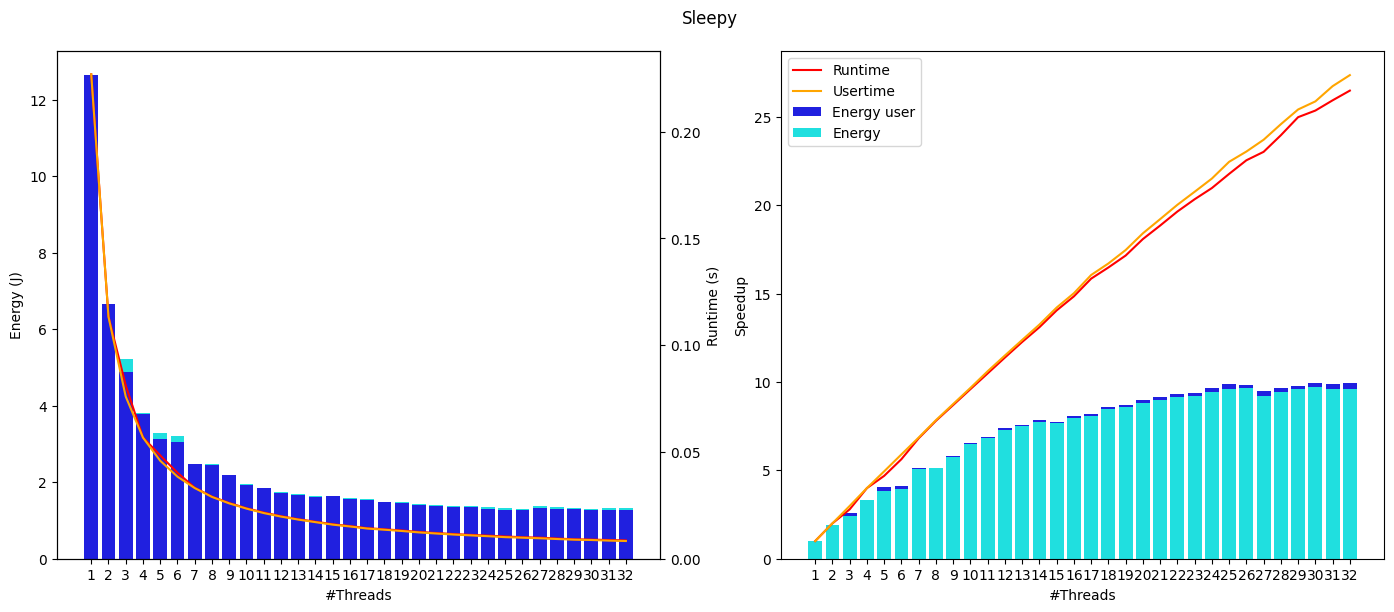

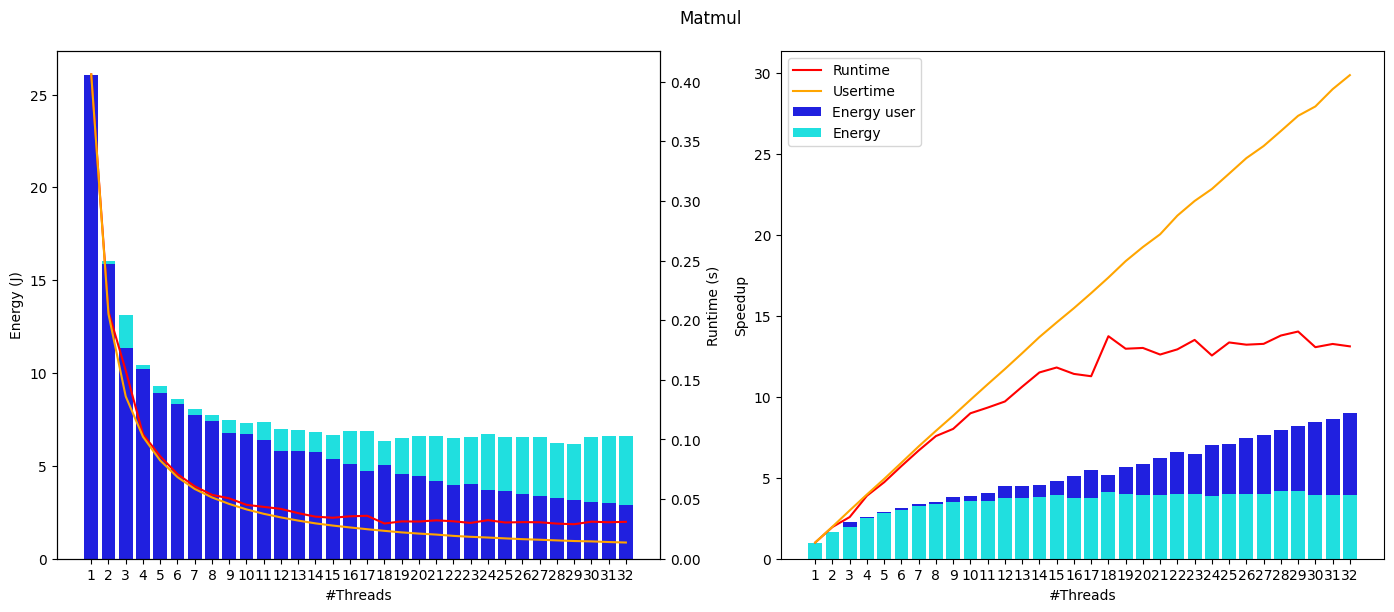

In [7]:
def plot(title, df0, df_speedup0):
    fig, (ax_energy1, ax_speedup) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)
    
    # Energy
    sns.barplot(df0, x='threads', y='energy', legend=False, color='cyan', ax=ax_energy1)
    sns.barplot(df0, x='threads', y='energy-user', legend=False, color='blue', ax=ax_energy1)
    ax_energy2 = ax_energy1.twinx()
    sns.lineplot(df0, x=df0.index, y='runtime', legend=False, color='r', ax=ax_energy2)
    sns.lineplot(df0, x=df0.index, y='usertime', legend=False, color='orange', ax=ax_energy2)

    ax_energy1.set_xlabel('#Threads')
    ax_energy1.set_ylabel('Energy (J)')
    ax_energy2.set_ylabel('Runtime (s)')
    ax_energy2.set_ylim((0, None))

    # Speedup
    sns.barplot(df_speedup0, x='threads', y='energy-user', label='Energy user', color='blue', ax=ax_speedup)
    sns.barplot(df_speedup0, x='threads', y='energy', label='Energy', color='cyan', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='runtime', label='Runtime', color='r', ax=ax_speedup)
    sns.lineplot(df_speedup0, x=df_speedup0.index, y='usertime', label='Usertime', color='orange', ax=ax_speedup)

    ax_speedup.set_xlabel('#Threads')
    ax_speedup.set_ylabel('Speedup')
    ax_speedup.set_ylim((0, None))

    plt.show()

plot('Math', df_math0, df_math_speedup0)
plot('Sleepy', df_sleepy0, df_sleepy_speedup0)
plot('Matmul', df_matmul0, df_matmul_speedup0)

# With busy threads

In [8]:
ENERGY = 'energy-user'

print('Math:')
for (busy, df_busy) in df_math.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best['threads'])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

print()

print('Sleepy:')
for (busy, df_busy) in df_sleepy.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best['threads'])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

print()

print('Matmul:')
for (busy, df_busy) in df_matmul.groupby('busy'):
    best = df_busy[df_busy[ENERGY] == df_busy[ENERGY].min()].iloc[0]
    threads = int(best[ENERGY])
    energy = best[ENERGY]
    print(f'{busy:2d} busy - Best: {threads:2d} threads @ {energy:.2f}J ({busy + threads} total workers)')

Math:
 0 busy - Best: 30 threads @ 1.27J (30 total workers)
 4 busy - Best: 31 threads @ 1.30J (35 total workers)
 8 busy - Best: 31 threads @ 1.34J (39 total workers)
12 busy - Best: 32 threads @ 1.32J (44 total workers)
16 busy - Best: 31 threads @ 1.08J (47 total workers)
20 busy - Best: 32 threads @ 1.03J (52 total workers)
24 busy - Best: 32 threads @ 1.01J (56 total workers)
28 busy - Best: 32 threads @ 1.01J (60 total workers)
32 busy - Best: 30 threads @ 1.16J (62 total workers)

Sleepy:
 0 busy - Best: 30 threads @ 1.27J (30 total workers)
 4 busy - Best: 31 threads @ 1.30J (35 total workers)
 8 busy - Best: 31 threads @ 1.34J (39 total workers)
12 busy - Best: 32 threads @ 1.32J (44 total workers)
16 busy - Best: 31 threads @ 1.08J (47 total workers)
20 busy - Best: 32 threads @ 1.03J (52 total workers)
24 busy - Best: 32 threads @ 1.01J (56 total workers)
28 busy - Best: 32 threads @ 1.01J (60 total workers)
32 busy - Best: 30 threads @ 1.16J (62 total workers)

Matmul:
 0 b

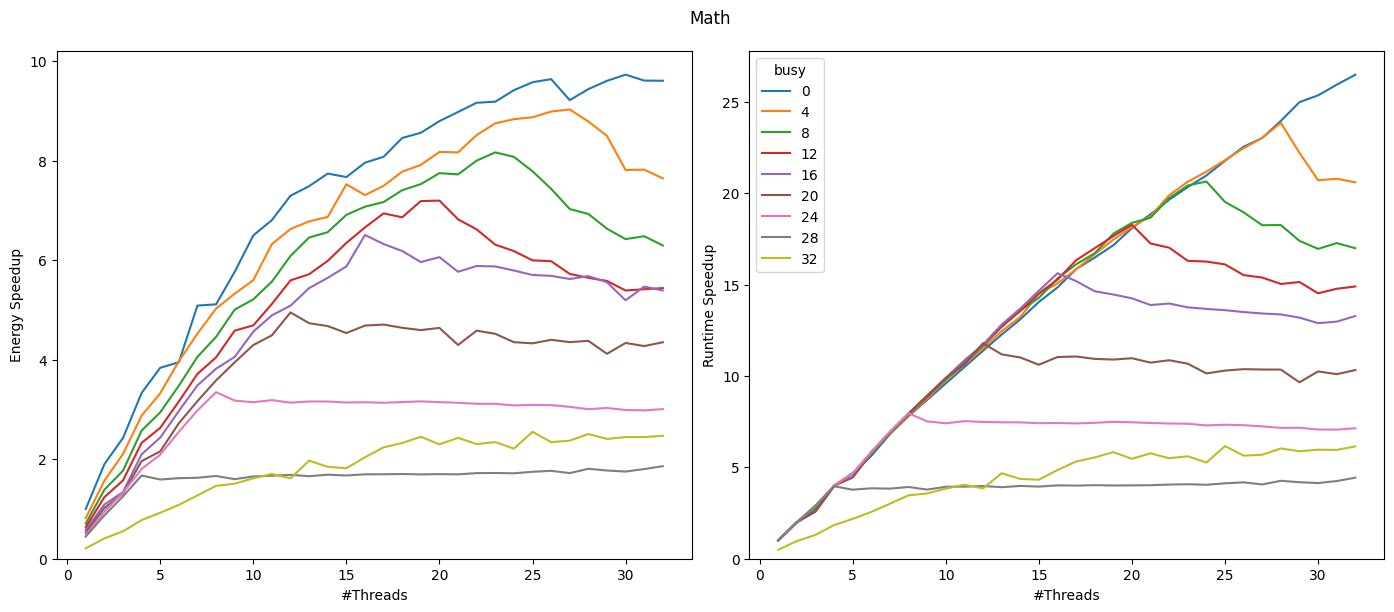

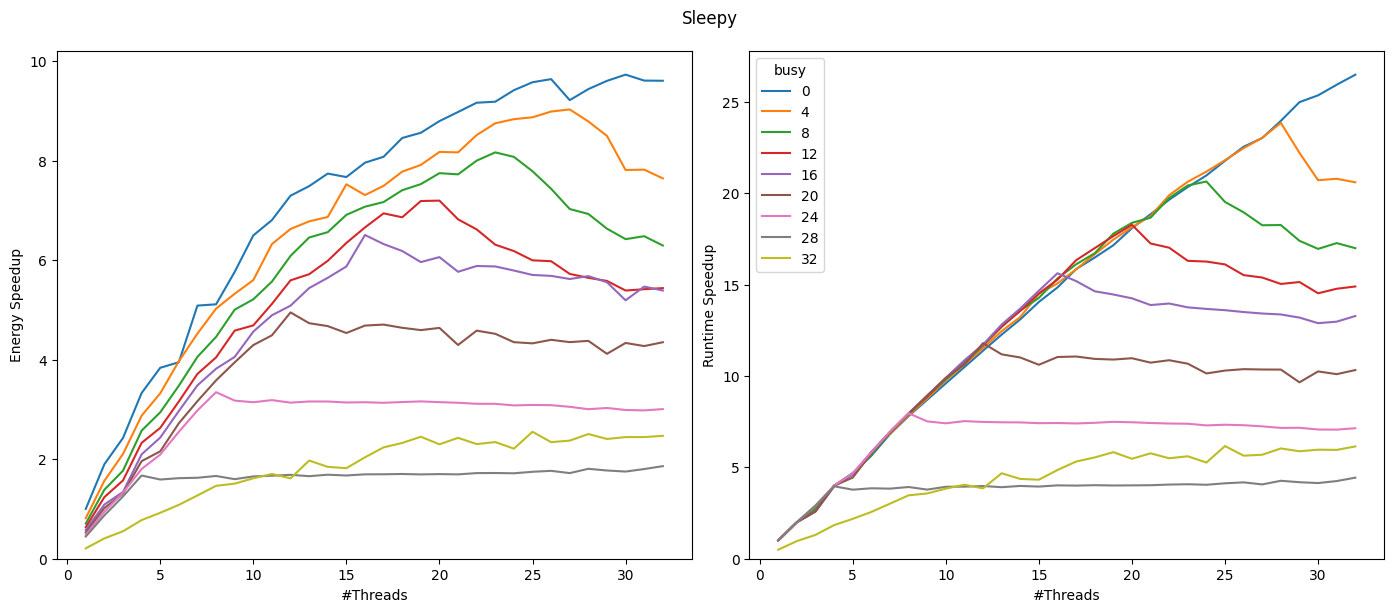

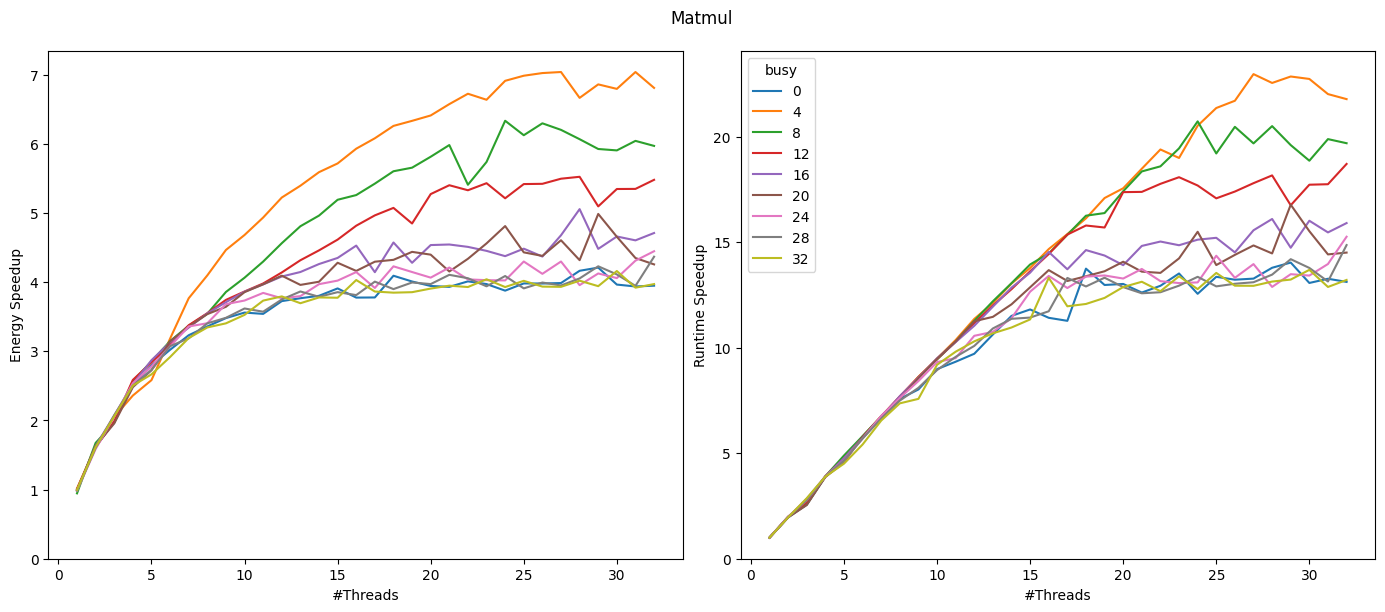

In [9]:
def plot(title, df):
    fig, (ax_energy, ax_runtime) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()

    # Energy
    sns.lineplot(df, x='threads', y='energy', hue=df['busy'].astype('category'), ax=ax_energy, legend=False)
    ax_energy.set_xlabel('#Threads')
    ax_energy.set_ylabel('Energy Speedup')
    ax_energy.set_ylim((0, None))

    # Runtime
    sns.lineplot(df, x='threads', y='runtime', hue=df['busy'].astype('category'), ax=ax_runtime)
    ax_runtime.set_xlabel('#Threads')
    ax_runtime.set_ylabel('Runtime Speedup')
    ax_runtime.set_ylim((0, None))

    plt.show()

plot('Math', df_math_speedup)
plot('Sleepy', df_sleepy_speedup)
plot('Matmul', df_matmul_speedup)

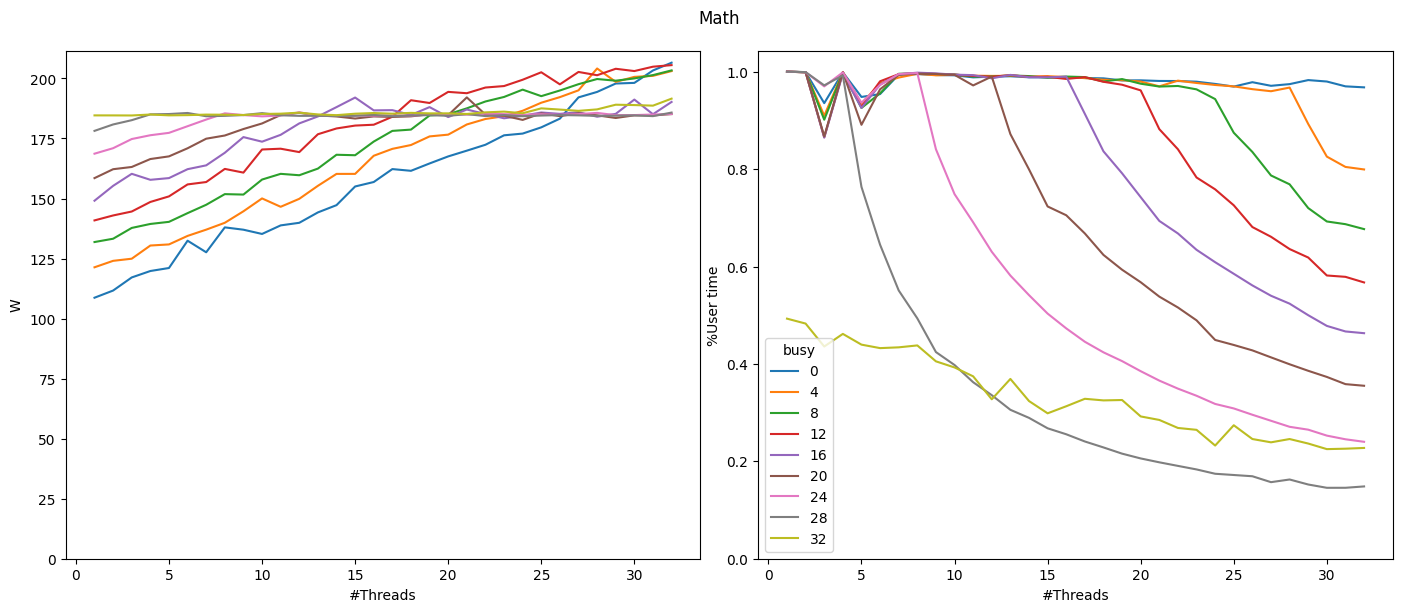

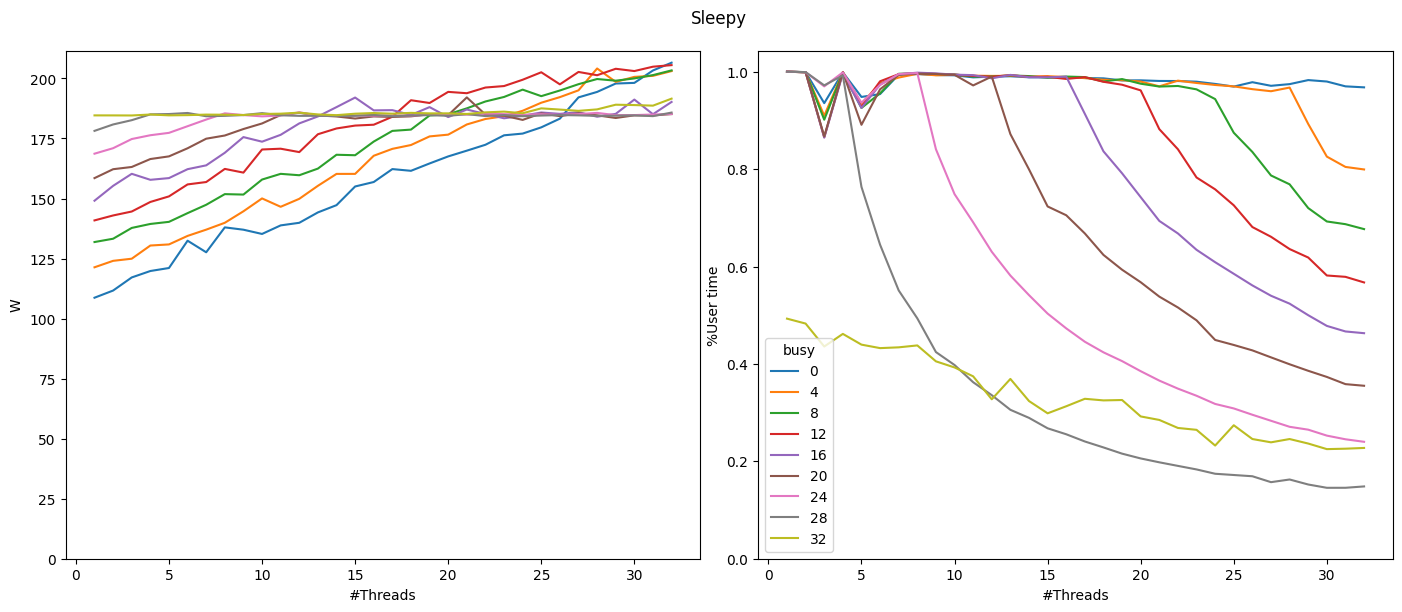

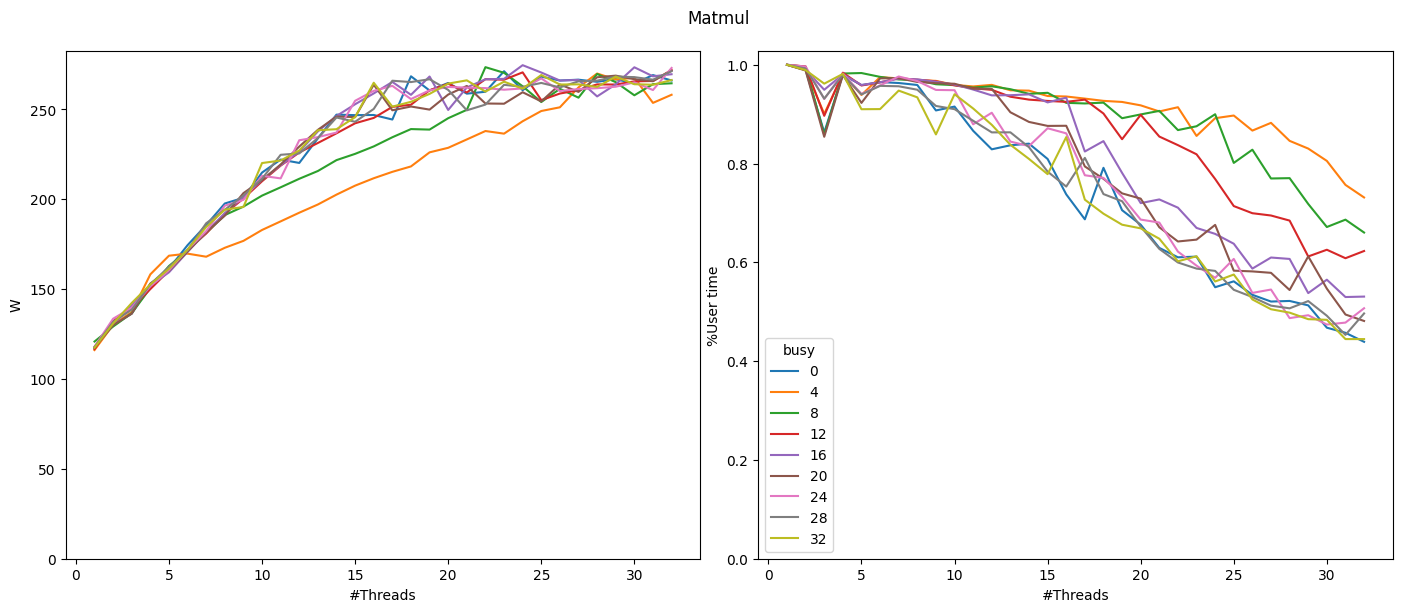

In [10]:
def plot(title, df):
    fig, (ax_power, ax_user) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle(title)
    fig.tight_layout()

    # Power
    sns.lineplot(df, x='threads', y='W', hue=df['busy'].astype('category'), ax=ax_power, legend=False)
    ax_power.set_xlabel('#Threads')
    ax_power.set_ylim((0, None))

    # User pct
    sns.lineplot(df, x='threads', y='user-pct', hue=df['busy'].astype('category'), ax=ax_user)
    ax_user.set_xlabel('#Threads')
    ax_user.set_ylabel('%User time')
    ax_user.set_ylim((0, None))

    plt.show()

plot('Math', df_math)
plot('Sleepy', df_sleepy)
plot('Matmul', df_matmul)